In [19]:
using Pkg; Pkg.activate("."); 
using StatsBase
using MUST
using PyPlot
using Interpolations
using PyCall
using KernelDensity
using DelimitedFiles
using Printf
using TSO

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"

MUST.@get_help visual
pl = pyimport("matplotlib.pylab");

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


# Opacity Source Comparison

In [20]:
output_name = "opacity_sources"

"opacity_sources"

## Models

In [21]:
eos_path   = MUST.@in_dispatch "input_data/DIS_MARCS_E_v0.4.3"
eosT_path  = "/u/peitner/Turbospectrum/opacity_tables/tests/DIS_MARCS_v0.4.3/"
sqEOS      = MUST.SquareGasEOS(eos_path);
eos, opa   = reload(SqEoS, joinpath(eos_path, "eos.hdf5")), reload(SqOpacity, joinpath(eos_path, "binned_opacities.hdf5"));
eosT, opaT = reload(SqEoS, joinpath(eosT_path, "eos.hdf5")), reload(SqOpacity, joinpath(eosT_path, "binned_opacities.hdf5"));

Stagger

In [22]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger_MARCS", folder=folder_stagger);
stagger_t      = MUST.Box("box_solar_stagger_MARCS_t", folder=folder_stagger);
colors_stagger = ["k"];
labels_stagger = ["Stagger"];
ls_stagger     = ["-"]
lw_stagger     = [2];

MURaM

In [23]:
data_muram = readdlm("muram_sun_av.txt", skipstart=1)
z_muram    = data_muram[:, 1]
d_muram    = data_muram[:, 2]
P_muram    = data_muram[:, 3]
T_muram    = data_muram[:, 4];

colors_muram = ["orange"];
labels_muram = ["MURaM (h-res)"];
ls_muram     = ["-"]
lw_muram     = [2];

In [24]:
data_muraml = readdlm("muram_sun_av_lres.txt", skipstart=1)
z_muraml    = data_muraml[:, 1]
d_muraml    = data_muraml[:, 2]
P_muraml    = data_muraml[:, 3]
T_muraml    = data_muraml[:, 4];

colors_muraml = ["b"];
labels_muraml = ["MURaM"];
ls_muraml     = ["--"]
lw_muraml     = [2];

Tabgen

In [25]:
folders_tabgen  = [MUST.@in_dispatch("data_tmps/TAB_sun_profile")]
snaps_tabgen    = [64]
labels_tabgen   = ["Tabgen @dispatch"]
tabgen, tabgen_t = [first(MUST.Boxes(folder1, snaps=[snaps_tabgen[i]])) for (i,folder1) in enumerate(folders_tabgen)], 
                   [last(MUST.Boxes(folder1, snaps=[snaps_tabgen[i]])) for (i,folder1) in enumerate(folders_tabgen)];
colors_tabgen = ["g"];
ls_tabgen     = ["--"]
lw_tabgen     = [2];

Legacy Stagger

In [26]:
folders_legacy = [MUST.@in_dispatch("data_tmps/DISSTAG_v0.1_profile")]
snaps_legacy   = [62]
labels_legacy  = ["Stein & Nordlund 1998 opacities @dispatch"]
legacy, legacy_t = [first(MUST.Boxes(folder1, snaps=[snaps_legacy[i]])) for (i,folder1) in enumerate(folders_legacy )], 
                   [last(MUST.Boxes(folder1, snaps=[snaps_legacy[i]])) for (i,folder1) in enumerate(folders_legacy )];
colors_legacy = ["b"];
ls_legacy     = [":"]
lw_legacy     = [2];

MARCS

In [27]:
folders_marcs = [MUST.@in_dispatch("data_tmps/DIS_MARCS_v0.4.4_profile_h")]
snaps_marcs   = [39]
labels_marcs  = ["MARCS (4 bins, h-res) @dispatch"]
marcs, marcs_t = [first(MUST.Boxes(folder1, snaps=[snaps_marcs[i]])) for (i,folder1) in enumerate(folders_marcs )], 
                   [last(MUST.Boxes(folder1, snaps=[snaps_marcs[i]])) for (i,folder1) in enumerate(folders_marcs )];
colors_marcs = ["r"];
ls_marcs      = ["-."]
lw_marcs      = [2];

MARCS (12 bins)

In [28]:
folders_marcs12 = [MUST.@in_dispatch("data_tmps/DIS_MARCS_v0.4.4_profile")]
snaps_marcs12   = [65]
labels_marcs12  = ["MARCS (4 bins) @dispatch"]
marcs12, marcs12_t = [first(MUST.Boxes(folder1, snaps=[snaps_marcs12[i]])) for (i,folder1) in enumerate(folders_marcs12)], 
                   [last(MUST.Boxes(folder1, snaps=[snaps_marcs12[i]])) for (i,folder1) in enumerate(folders_marcs12)];
colors_marcs12 = ["magenta"];
ls_marcs12     = ["-."]
lw_marcs12     = [2];

AESOPUS

In [29]:
folders_aeso = [MUST.@in_dispatch("data_tmps/DIS_AESOPUS_v1.3.2_profile")]
snaps_aeso   = [65]
labels_aeso  = ["AESOPUS @dispatch"]
aeso, aeso_t = [first(MUST.Boxes(folder1, snaps=[snaps_aeso[i]])) for (i,folder1) in enumerate(folders_aeso)], 
                   [last(MUST.Boxes(folder1, snaps=[snaps_aeso[i]])) for (i,folder1) in enumerate(folders_aeso)];
colors_aeso = ["cyan"];
ls_aeso     = ["--"]
lw_aeso     = [2.5];

## Average models

In [30]:
stats(fx, fy, model, x, y) = begin
    z = x == :z ? MUST.axis(model, :z) : MUST.plane_statistic(fx, model, x)
    d = MUST.plane_statistic(fy, model, y)
    z,d
end

stats(fx, fy, model_vec::Vector, x, y) = begin
    model = first(model_vec)
    z = ((x==:z) | (x==:τ_ross)) ? MUST.axis(model, x, 3) : MUST.plane_statistic(fx, model, x)
    d = MUST.plane_statistic(fy, model, y)
    z,d
end

average(args...) = stats(mean, mean, args...)

average (generic function with 1 method)

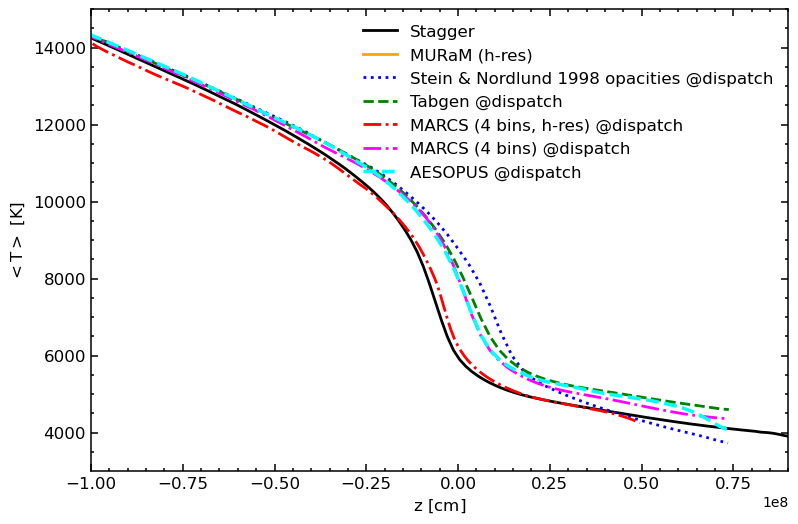

In [31]:
close()

f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)
ax = [ax]


## Stagger
ax[1].plot(average(stagger, :z, :T)..., color=colors_stagger[1], label=labels_stagger[1], ls=ls_stagger[1], lw=lw_stagger[1])

## MURaM
ax[1].plot(z_muram, T_muram, color=colors_muram[1], label=labels_muram[1], ls=ls_muram[1], lw=lw_muram[1])

## MARCS 12
ax[1].plot(average(legacy, :z, :T)..., color=colors_legacy[1], label=labels_legacy[1], ls=ls_legacy[1], lw=lw_legacy[1])

## Tabgen
ax[1].plot(average(tabgen, :z, :T)..., color=colors_tabgen[1], label=labels_tabgen[1], ls=ls_tabgen[1], lw=lw_tabgen[1])

## MARCS 4
ax[1].plot(average(marcs, :z, :T)..., color=colors_marcs[1], label=labels_marcs[1], ls=ls_marcs[1], lw=lw_marcs[1])

## MARCS 12
ax[1].plot(average(marcs12, :z, :T)..., color=colors_marcs12[1], label=labels_marcs12[1], ls=ls_marcs12[1], lw=lw_marcs12[1])

## AESOPUS
ax[1].plot(average(aeso, :z, :T)..., color=colors_aeso[1], label=labels_aeso[1], ls=ls_aeso[1], lw=lw_aeso[1])



## Setup
ax[1].legend(framealpha=0, fontsize="large")
ax[1].set_xlim(-1.e8, 0.9e8)
ax[1].set_ylim(3000, 15000)
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="large")
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="large")

f.savefig("tz_$(output_name).pdf", bbox_inches="tight")

gcf()

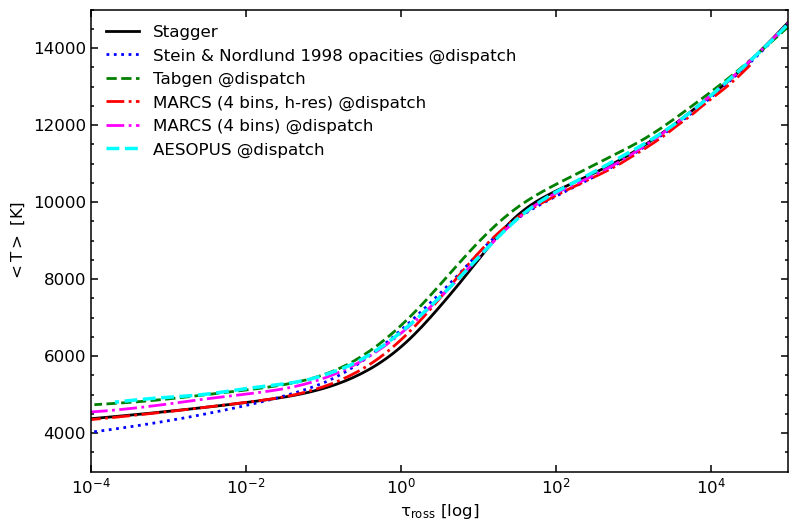

In [32]:
close()

f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)
ax = [ax]


## Stagger
ax[1].plot(average(stagger_t, :τ_ross, :T)..., color=colors_stagger[1], label=labels_stagger[1], ls=ls_stagger[1], lw=lw_stagger[1])

## MARCS 12
ax[1].plot(average(legacy_t, :τ_ross, :T)..., color=colors_legacy[1], label=labels_legacy[1], ls=ls_legacy[1], lw=lw_legacy[1])

## Tabgen
ax[1].plot(average(tabgen_t, :τ_ross, :T)..., color=colors_tabgen[1], label=labels_tabgen[1], ls=ls_tabgen[1], lw=lw_tabgen[1])

## MARCS 4
ax[1].plot(average(marcs_t, :τ_ross, :T)..., color=colors_marcs[1], label=labels_marcs[1], ls=ls_marcs[1], lw=lw_marcs[1])

## MARCS 12
ax[1].plot(average(marcs12_t, :τ_ross, :T)..., color=colors_marcs12[1], label=labels_marcs12[1], ls=ls_marcs12[1], lw=lw_marcs12[1])

## AESOPUS
ax[1].plot(average(aeso_t, :τ_ross, :T)..., color=colors_aeso[1], label=labels_aeso[1], ls=ls_aeso[1], lw=lw_aeso[1])



## Setup
ax[1].legend(framealpha=0, fontsize="large")
ax[1].set_xlim(1e-4, 1e5)
ax[1].set_ylim(3000, 15000)
ax[1].set_xlabel(L"\rm \tau_{ross} \ [log]", fontsize="large")
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="large")
ax[1].set_xscale("log")

f.savefig("ttau_$(output_name).pdf", bbox_inches="tight")

gcf()

In [33]:
tabgen[1].data[:pg_comp2]  = exp.(lookup(eosT, :lnPg, log.(tabgen[1][:d]),  log.(tabgen[1][:T])))
marcs[1].data[:pg_comp2]   = exp.(lookup(eosT, :lnPg, log.(marcs[1][:d]),   log.(marcs[1][:T])))
marcs12[1].data[:pg_comp2] = exp.(lookup(eosT, :lnPg, log.(marcs12[1][:d]), log.(marcs12[1][:T])))
legacy[1].data[:pg_comp2]  = exp.(lookup(eosT, :lnPg, log.(legacy[1][:d]),  log.(legacy[1][:T])))
aeso[1].data[:pg_comp2]    = exp.(lookup(eosT, :lnPg, log.(aeso[1][:d]),    log.(aeso[1][:T])));;

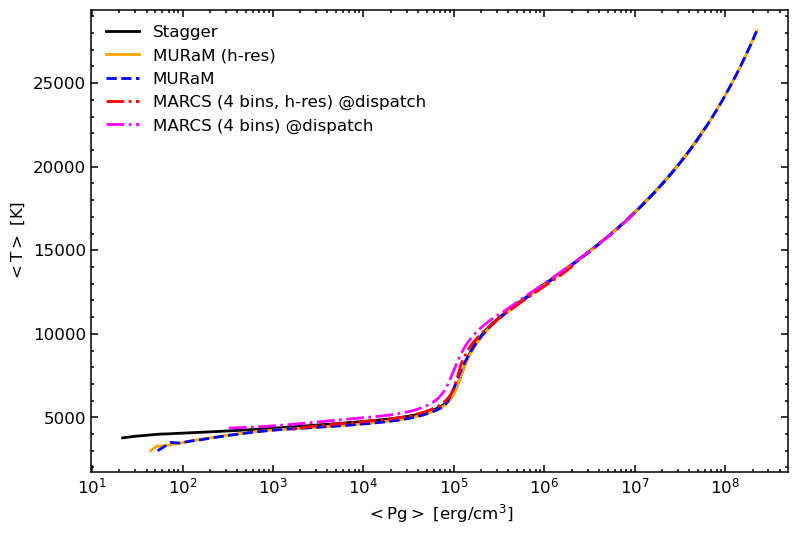

In [34]:
close()

f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)
ax = [ax]


## Stagger
ax[1].plot(average(stagger, :Pg, :T)..., color=colors_stagger[1], label=labels_stagger[1], ls=ls_stagger[1], lw=lw_stagger[1])

##MURaM
ax[1].plot(P_muram, T_muram, color=colors_muram[1], label=labels_muram[1], ls=ls_muram[1], lw=lw_muram[1])
ax[1].plot(P_muraml, T_muraml, color=colors_muraml[1], label=labels_muraml[1], ls=ls_muraml[1], lw=lw_muraml[1])

## Legacy
#ax[1].plot(average(legacy, :pg_comp2, :T)..., color=colors_legacy[1], label=labels_legacy[1], ls=ls_legacy[1], lw=lw_legacy[1])

## Tabgen
#ax[1].plot(average(tabgen, :pg_comp2, :T)..., color=colors_tabgen[1], label=labels_tabgen[1], ls=ls_tabgen[1], lw=lw_tabgen[1])

## MARCS 4
ax[1].plot(average(marcs, :pg_comp2, :T)..., color=colors_marcs[1], label=labels_marcs[1], ls=ls_marcs[1], lw=lw_marcs[1])

## MARCS 12
ax[1].plot(average(marcs12, :pg_comp2, :T)..., color=colors_marcs12[1], label=labels_marcs12[1], ls=ls_marcs12[1], lw=lw_marcs12[1])

## AESOPUS
#ax[1].plot(average(aeso, :pg_comp2, :T)..., color=colors_aeso[1], label=labels_aeso[1], ls=ls_aeso[1], lw=lw_aeso[1])



## Setup
ax[1].legend(framealpha=0, fontsize="large")
#ax[1].set_xlim(1e-4, 1e5)
#ax[1].set_ylim(3000, 15000)
ax[1].set_xlabel(L"\rm <Pg> \ [erg/cm^3]", fontsize="large")
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="large")
ax[1].set_xscale("log")

f.savefig("tpg_$(output_name).pdf", bbox_inches="tight")

gcf()

In [35]:
#f = MUST.@in_dispatch("data/TAB_sun_profile")
#
#snap = dispatch.snapshot(10, data=f)
#
# Units for conversion to CGS
#units = MUST.StaggerCGS(snap)

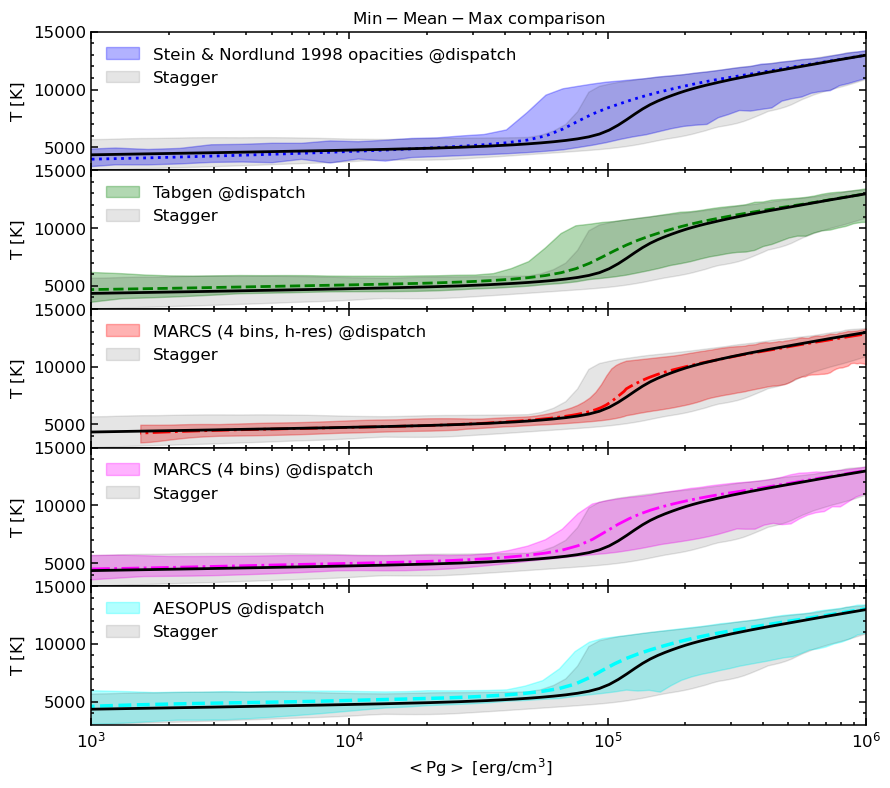

In [36]:
close()

f, ax = plt.subplots(5, 1, figsize=(10,9), sharex=true, sharey=true)
basic_plot!.(ax)
plt.subplots_adjust(hspace=0)
#ax = [ax]


## Legacy
xmi, ymi = stats(mean, minimum, legacy, :pg_comp2, :T)
xma, yma = stats(mean, maximum, legacy, :pg_comp2, :T)
ax[1].fill_between(xmi, ymi, yma, color=colors_legacy[1], label=labels_legacy[1], alpha=0.3)
ax[1].plot(average(legacy, :pg_comp2, :T)..., color=colors_legacy[1], ls=ls_legacy[1], lw=lw_legacy[1])

## Tabgen
xmi, ymi = stats(mean, minimum, tabgen, :pg_comp2, :T)
xma, yma = stats(mean, maximum, tabgen, :pg_comp2, :T)
ax[2].fill_between(xmi, ymi, yma, color=colors_tabgen[1], label=labels_tabgen[1], alpha=0.3)
ax[2].plot(average(tabgen, :pg_comp2, :T)..., color=colors_tabgen[1], ls=ls_tabgen[1], lw=lw_tabgen[1])

## MARCS 4
xmi, ymi = stats(mean, minimum, marcs, :pg_comp2, :T)
xma, yma = stats(mean, maximum, marcs, :pg_comp2, :T)
ax[3].fill_between(xmi, ymi, yma, color=colors_marcs[1], label=labels_marcs[1], alpha=0.3)
ax[3].plot(average(marcs, :pg_comp2, :T)..., color=colors_marcs[1], ls=ls_marcs[1], lw=lw_marcs[1])

## MARCS 12
xmi, ymi = stats(mean, minimum, marcs12, :pg_comp2, :T)
xma, yma = stats(mean, maximum, marcs12, :pg_comp2, :T)
ax[4].fill_between(xmi, ymi, yma, color=colors_marcs12[1], label=labels_marcs12[1], alpha=0.3)
ax[4].plot(average(marcs12, :pg_comp2, :T)..., color=colors_marcs12[1], ls=ls_marcs12[1], lw=lw_marcs12[1])

## AESOPUS
xmi, ymi = stats(mean, minimum, aeso, :pg_comp2, :T)
xma, yma = stats(mean, maximum, aeso, :pg_comp2, :T)
ax[5].fill_between(xmi, ymi, yma, color=colors_aeso[1], label=labels_aeso[1], alpha=0.3)
ax[5].plot(average(aeso, :pg_comp2, :T)..., color=colors_aeso[1], ls=ls_aeso[1], lw=lw_aeso[1])


## Setup
ax[1].set_xlim(1e3, 1e6)
ax[1].set_ylim(3000, 15000)
for i in eachindex(ax)
    ## Stagger
    ax[i].plot(average(stagger, :pp, :T)..., color=colors_stagger[1], ls=ls_stagger[1], lw=lw_stagger[1])
    xmi, ymi = stats(mean, minimum, stagger, :pp, :T)
    xma, yma = stats(mean, maximum, stagger, :pp, :T)
    ax[i].fill_between(xmi, ymi, yma, color=colors_stagger[1], label=labels_stagger[1], alpha=0.1, zorder=1)

    ax[i].set_ylabel(L"\rm T \ [K]", fontsize="large")
    ax[i].set_xscale("log")
    ax[i].legend(framealpha=0, fontsize="large")
end

ax[end].set_xlabel(L"\rm <Pg> \ [erg/cm^3]", fontsize="large")
ax[1].set_title(L"\rm Min - Mean - Max \ comparison")

f.savefig("minmax_tpg_$(output_name).pdf", bbox_inches="tight")

gcf()